<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tabnet-on-handmade" data-toc-modified-id="Tabnet-on-handmade-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tabnet on handmade</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
from pytorch_tabnet.tab_network import TabNet

In [6]:
from code.dataloader_handmade import AgeGroupHandmadeDataset
from code.encoder_tabnet import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier, train_tabnet

In [7]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 10
LR = 0.002
NUM_EPOCHS = 10

cat_vocab_sizes = [204]
cat_embedding_dim = 20
num_input_dim = 4
NUM_OBS = 30000
SCHEDULER_EPOCHS = 2

In [8]:
dataset = AgeGroupHandmadeDataset()

In [9]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [10]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

targets = dataset.y

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

## Tabnet on handmade

In [11]:
from code.classifier_tabnet import Classifier

In [28]:
clf = Classifier(
    input_dim=dataset.X.shape[1],
    embedding_dim=EMBEDDING_DIM,
    out_dim=4,
)

In [29]:
clf.to(device);

In [30]:
NUM_EPOCHS = 30
LR = 0.02

In [31]:
optimizer = optim.Adam(clf.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [32]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

In [33]:
for epoch in tqdm(range(NUM_EPOCHS)):
    clf.train()
    correct = 0
    total = 0
    epoch_losses = []
    for (sequences, labels) in trainloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = clf(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 0.3)
        optimizer.step()

        pred_labels = torch.argmax(outputs, dim=1)
        correct += sum(labels == pred_labels)
        total += len(sequences)
        epoch_losses.append(loss.item())

    train_acc = correct / total
    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)
    train_accuracy.append(train_acc.item())

    clf.eval()
    correct = 0
    total = 0
    epoch_val_losses = []
    for sequences, labels in testloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = clf(sequences)
            loss = criterion(outputs, labels)

            pred_labels = torch.argmax(outputs, dim=1)
            correct += sum(labels == pred_labels)
            total += len(sequences)
            epoch_val_losses.append(loss.item())

    val_acc = correct / total
    epoch_val_loss = torch.tensor(epoch_val_losses).mean()
    val_losses.append(epoch_val_loss)
    val_accuracy.append(val_acc.item())

    scheduler.step(epoch_val_loss)

    print(f'Epoch {epoch}, train acc: {train_acc}, val acc: {val_acc}')
    print(f'train loss: {epoch_loss}; val loss: {epoch_val_loss}')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0, train acc: 0.3284761905670166, val acc: 0.42855554819107056
train loss: 1.3558132648468018; val loss: 1.2360025644302368
Epoch 1, train acc: 0.47380951046943665, val acc: 0.5278888940811157
train loss: 1.1265696287155151; val loss: 1.05453622341156
Epoch 2, train acc: 0.5425238013267517, val acc: 0.5526666641235352
train loss: 1.0123931169509888; val loss: 0.9963223934173584
Epoch 3, train acc: 0.5719524025917053, val acc: 0.5517777800559998
train loss: 0.9586978554725647; val loss: 1.0148885250091553
Epoch 4, train acc: 0.5894761681556702, val acc: 0.5736666917800903
train loss: 0.9234438538551331; val loss: 0.9535168409347534
Epoch 5, train acc: 0.6030952334403992, val acc: 0.5671111345291138
train loss: 0.8944997191429138; val loss: 0.9748910665512085
Epoch 6, train acc: 0.6163333058357239, val acc: 0.5772222280502319
train loss: 0.864996075630188; val loss: 0.9446609020233154
Epoch 7, train acc: 0.628333330154419, val acc: 0.5796666741371155
train loss: 0.8384194374084473;

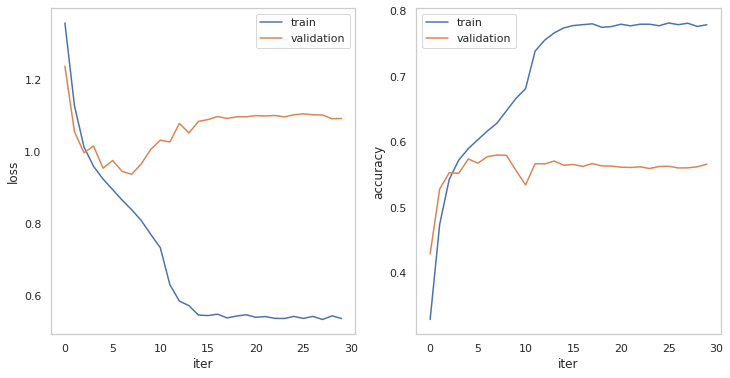

In [35]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.ylabel('accuracy');
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.legend()

plt.savefig(f'plots/tabnet_handmade_{EMBEDDING_DIM}_{NUM_EPOCHS}.png')

In [39]:
val_accuracy[-1]

0.565666675567627